# Learn from https://www.youtube.com/watch?v=0YLZXjMHA-8 with modification

In [39]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp, GATConv
from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from torch_geometric.loader import DataLoader



In [3]:
data = MoleculeNet(root='./data', name='ESOL')

Processing...
Done!


In [18]:
data[0]

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

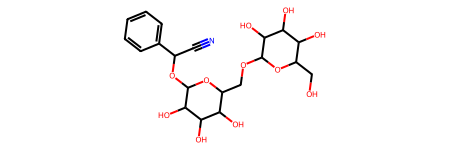

In [20]:
processed_data = Chem.MolFromSmiles(data[0].smiles)
processed_data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [23]:
embedding_size = 32
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_features, embedding_size) #Create embedding of size 32
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.fc = Linear(embedding_size*2, 1)
    def forward(self, x, edge_index, batch_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        out = self.fc(x)
        
        return out, x

In [40]:

class Attention_model(torch.nn.Module):
    def __init__(self):
        super(Attention_model, self).__init__()
        self.conv1 = GATConv(data.num_features, embedding_size, heads=8, dropout=0.2)
        self.conv2 = GATConv(embedding_size*8, embedding_size, heads=1,  dropout=0.2)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=1, concat=False, dropout=0.2)
        self.fc = Linear(embedding_size*2, 1)
    def forward(self, x, edge_index, batch_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        out = self.fc(x)
        
        return out, x        

In [24]:
model1 = GCN()
print(sum(p.numel() for p in model1.parameters()))

2497


In [41]:
model2 = Attention_model()
print(sum(p.numel() for p in model2.parameters()))


12545


In [35]:
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=1e-5)
device ='cuda'
model1 = model1.to(device)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)
dataset = Dataset(data)
train, val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)
def train_one_epoch():
    model1.train()
    loss_all = 0
    for i in train_loader:
        i = i.to(device)
        optimizer.zero_grad()
        output, _ = model1(i.x.float(), i.edge_index, i.batch)
        loss = F.mse_loss(output.view(-1), i.y.view(-1))
        loss.backward()
        loss_all += loss.item() * i.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


In [36]:
for i in range(2000):
    out = train_one_epoch()
    if i % 100 == 0:
        print(f'Epoch: {i}, Loss: {out}')

Epoch: 0, Loss: 4.410949264027327
Epoch: 100, Loss: 0.7992704333592942
Epoch: 200, Loss: 0.545531616110495
Epoch: 300, Loss: 0.5313898342477773
Epoch: 400, Loss: 0.38415738200136934
Epoch: 500, Loss: 0.3129399978202621
Epoch: 600, Loss: 0.27414555233095805
Epoch: 700, Loss: 0.28381240699944105
Epoch: 800, Loss: 0.26595066048353583
Epoch: 900, Loss: 0.25996550739207974
Epoch: 1000, Loss: 0.20529603218027864
Epoch: 1100, Loss: 0.17342784994193033
Epoch: 1200, Loss: 0.20433490093954387


KeyboardInterrupt: 

In [43]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=1e-5)
device ='cuda'
model2 = model2.to(device)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)
dataset = Dataset(data)
train, val = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)
def train_one_epoch2():
    model1.train()
    loss_all = 0
    for i in train_loader:
        i = i.to(device)
        optimizer.zero_grad()
        output, _ = model2(i.x.float(), i.edge_index, i.batch)
        loss = F.mse_loss(output.view(-1), i.y.view(-1))
        loss.backward()
        loss_all += loss.item() * i.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [44]:
for i in range(200):
    out = train_one_epoch2()
    if i % 10 == 0:
        print(f'Epoch: {i}, Loss: {out}')

Epoch: 0, Loss: 5.6525227513952245
Epoch: 10, Loss: 2.3210286618863227
Epoch: 20, Loss: 2.042888270132037
Epoch: 30, Loss: 1.7196878439036187
Epoch: 40, Loss: 1.4623244384330505
Epoch: 50, Loss: 1.281795923760035
Epoch: 60, Loss: 1.3490368203071266
Epoch: 70, Loss: 1.0556985418397855
Epoch: 80, Loss: 0.9870098313091865
Epoch: 90, Loss: 0.9352709435149285
Epoch: 100, Loss: 0.8959447626820698
Epoch: 110, Loss: 0.9396095881166384
Epoch: 120, Loss: 0.9638678285304626
Epoch: 130, Loss: 0.8103636808173601
Epoch: 140, Loss: 0.8226660527000131
Epoch: 150, Loss: 0.8012339284649719
Epoch: 160, Loss: 0.8408007384138646
Epoch: 170, Loss: 0.71270785088819
Epoch: 180, Loss: 0.7695176164441199
Epoch: 190, Loss: 0.7411818085516806
